#  Intel Image Classification. 
## Image Scene Classification of Multiclass. 

## Modeling with VGG16

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline


### Image preprocessing

In [3]:
train_path = 'Dataset - Large\seg_train'
valid_path = 'Dataset - Large\seg_test'
test_path = 'Dataset - Large\seg_pred'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,width_shift_range=.15,height_shift_range=0.2,zoom_range=0.2,shear_range=0.2,rotation_range=90,horizontal_flip=True).flow_from_directory(
    directory=train_path, target_size=(150,150), batch_size=256)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(150,150), batch_size=256)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(150,150),class_mode = None, batch_size=256, shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 84 images belonging to 1 classes.


**Observations:**
1. Rescaling should be done to validation and test set as well.
2. model will be trained on images of size 150 * 150
3. Test batches are not shuffled. This will help in predicting class for each image in test set.
4. Overfitting is observed in modelling
5. Data Augmentaion is done to reduce overfitting
6. Data Augmentation that is done to train set should not be repeated to validation and test set.

## Pretrained VGG16 model

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
image_width, image_height = 150,150
vgg16 = VGG16(input_shape=(image_width,image_height,3),include_top=False, weights="imagenet")
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

**Observations:**
1. making include_top=False, gives us the flexibility to train the model with images size pf our choice
2. weights are imported from imagenet

## Finetuning the model

In [6]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
x = vgg16.layers[-1].output
flatten=Flatten()(x)
bn=BatchNormalization()(flatten)
do=Dropout(0.3)(bn)
do = Dense(units=32, activation='relu')(do)
output = Dense(units=6, activation='softmax')(do)
model = Model(inputs=vgg16.input, outputs=output)

In [7]:
for layer in model.layers[:-10]:
    layer.trainable=False

**Observations:**
1. Flatten layer is added followed by a batch normalization and two dense layers
2. Last layer is softmax and contain 6 units, because we have 6 classes of images
3. All layers are frozen except last ten

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics = ['acc'])

## Training the model

In [11]:
history = model.fit(train_batches,validation_data=valid_batches, epochs=8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 55 steps, validate for 12 steps
Epoch 1/8
55/55 [==============================] - 4681s 85s/step - loss: 0.6739 - acc: 0.7532 - val_loss: 1.1744 - val_acc: 0.7427
Epoch 2/8
55/55 [==============================] - 4678s 85s/step - loss: 0.4028 - acc: 0.8551 - val_loss: 1.3752 - val_acc: 0.7600
Epoch 3/8
55/55 [==============================] - 4032s 73s/step - loss: 0.3485 - acc: 0.8744 - val_loss: 0.3852 - val_acc: 0.8847
Epoch 4/8
55/55 [==============================] - 3871s 70s/step - loss: 0.3289 - acc: 0.8828 - val_loss: 0.4716 - val_acc: 0.8743
Epoch 5/8
55/55 [==============================] - 3871s 70s/step - loss: 0.2915 - acc: 0.8942 - val_loss: 0.3858 - val_acc: 0.8797
Epoch 6/8
55/55 [==============================] - 3870s 70s/step - loss: 0.2747 - acc: 0.9006 - val_loss: 0.3175 - val_acc: 0.8993
Epoch 7/8
55/55 [==============================] - 3867s 70s/step - loss: 0.2701 - acc: 0.9046 - val_loss: 0.4006 - 

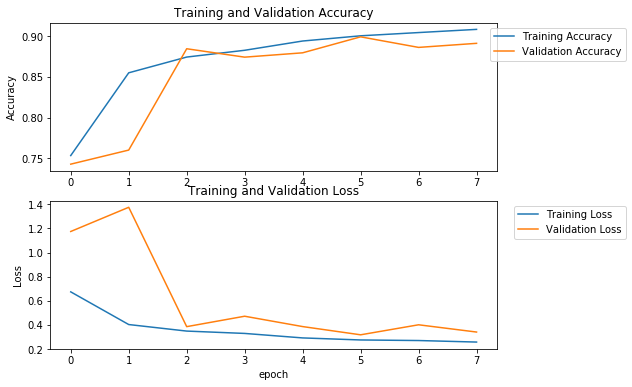

In [18]:
import matplotlib.pyplot as plt

acc      = model.history.history['acc']
val_acc  = model.history.history['val_acc']
loss     = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


**Observations:**
1. In the first few iterations the loss/accuracy changes a lot
2. There is some overfitting in the model.
3. But the overfitting is not very severe.

## Plotting confusion matrix

In [15]:
model.save('vggModelNew.h5')

In [16]:
new_model = tf.keras.models.load_model('vggModelNew.h5')

In [17]:
predictionsV = new_model.predict(x=valid_batches, steps=len(valid_batches), verbose=0)

In [19]:
scores = new_model.evaluate(valid_batches, verbose=0)
print("%s: %.2f%%" % (new_model.metrics_names[1], scores[1]*100))

  ...
    to  
  ['...']
acc: 89.13%


**Observations:**
1. After training, the model is saved to an h5 file.
2. The validation accuracy is 89.13%

In [20]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=predictionsV.argmax(axis=1))

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 73  55  83  85  80  61]
 [ 86  84  75  84  81  64]
 [ 88  92  86 101 114  72]
 [ 89  93  82  87  99  75]
 [ 91  84  78  91  95  71]
 [ 85  69  76  99 103  69]]


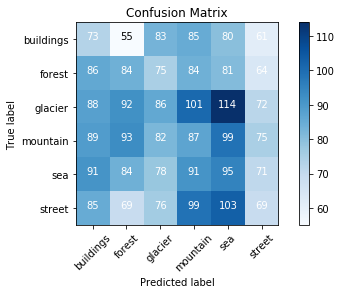

In [22]:
cm_plot_labels = ['buildings','forest','glacier','mountain','sea','street']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Prediction on test images

In [23]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [24]:
test_batches.filenames[:5]

['unknown\\101.jpg',
 'unknown\\103.jpg',
 'unknown\\11.jpg',
 'unknown\\110.jpg',
 'unknown\\117.jpg']

In [25]:
preds_cls_idx = predictions.argmax(axis=-1)

In [26]:
# https://stackoverflow.com/questions/57516673/how-to-perform-prediction-using-predict-generator-on-unlabeled-test-data-in-kera
import numpy as np
idx_to_cls = {v: k for k, v in train_batches.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
filenames_to_cls = list(zip(test_batches.filenames, preds_cls))

In [27]:
filenames_to_cls[:5]

[('unknown\\101.jpg', 'glacier'),
 ('unknown\\103.jpg', 'buildings'),
 ('unknown\\11.jpg', 'glacier'),
 ('unknown\\110.jpg', 'sea'),
 ('unknown\\117.jpg', 'mountain')]

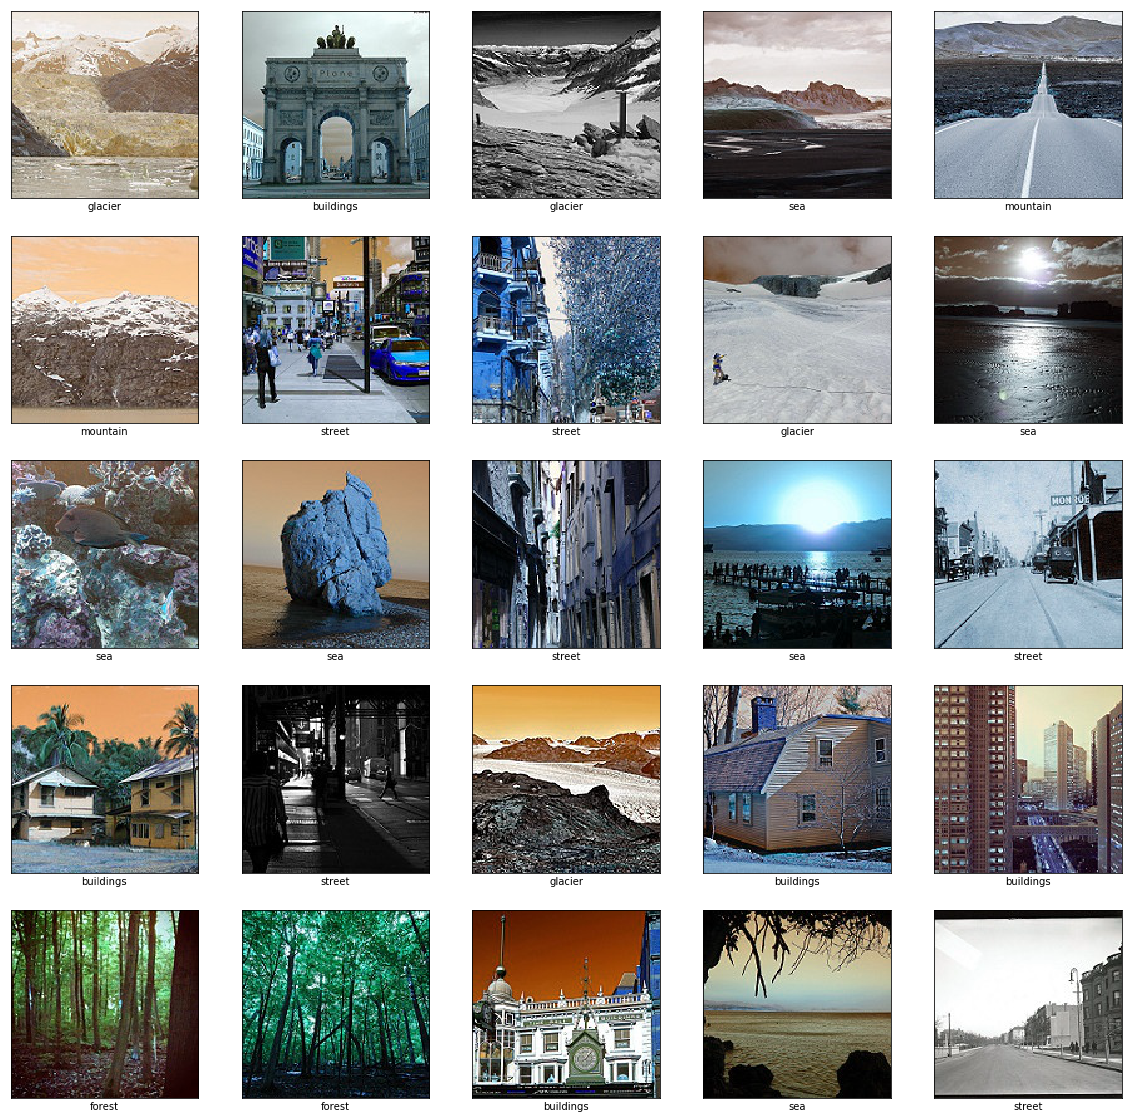

In [28]:
import cv2 as cv
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv.imread(r'Dataset - Large\\seg_pred\\'+filenames_to_cls[i][0])
    plt.imshow(img)
    plt.xlabel(filenames_to_cls[i][1])
plt.show()

**Observations:**
1. The class labels for test images is not given. Hence we cant calculate its accuracy.
2. The results on test batches are quite good.
3. The classes in this dataset are very similar to classes in imagenet dataset, hence just by retraining last few layers, VGG16 model has given very good performance on test set